In [4]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dotenv import load_dotenv

In [5]:
# получение данных о визитах и регистрациях по API
#DATE_BEGIN = '2023-03-01'
#DATE_END = '2023-09-01'
#API_URL = 'https://data-charts-api.hexlet.app'

load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

resp_vsts = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
resp_registr = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})

In [6]:
# преобразуем JSON-содержимого ответа
visits = pd.DataFrame(resp_vsts.json())
registrations = pd.DataFrame(resp_registr.json())

In [7]:
#обрабатываем данные о визитах, фильтрует их, выбирает последние 
#посещения по каждому идентификатору визита, а затем создает таблицу, показывающую количество визитов по дням и платформам
visits = visits[visits['platform'] != 'bot']
visits['datetime'] = pd.to_datetime(visits['datetime'])
last_date = visits.groupby('visit_id')['datetime'].max().reset_index()
visits = pd.merge(last_date, visits, on=['visit_id', 'datetime'], how='left')
DataFrame_vsts = visits.groupby([pd.Grouper(key='datetime', freq='D'), 'platform']).agg({'visit_id': 'count'}).reset_index()

In [8]:
#создаем таблицу, которая показывает количество регистраций по дням и платформам
registrations['datetime'] = pd.to_datetime(registrations['datetime'])
DataFrame_registr = registrations.groupby([pd.Grouper(key='datetime', freq='D'), 'platform']).agg({'user_id': 'count'}).reset_index()

In [9]:
DataFrame_vsts.columns = ['date_group', 'platform', 'visits']
DataFrame_registr.columns = ['date_group', 'platform', 'registrations']
conv = pd.merge(DataFrame_vsts, DataFrame_registr, on=['date_group', 'platform'], how='outer')
conv['conversion'] = conv['registrations'] / conv['visits'] * 100
conv.to_json('./conversion.json')
conv

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355
...,...,...,...,...,...
547,2023-08-30,ios,66,40,60.606061
548,2023-08-30,web,1227,34,2.770986
549,2023-08-31,android,57,42,73.684211
550,2023-08-31,ios,50,36,72.000000


In [10]:
#данные о рекламе
ads_raw = pd.read_csv('ads.csv')
ads_raw['date'] = pd.to_datetime(pd.to_datetime(ads_raw['date']).dt.date)

In [11]:
#подготовка датафрейма по рекламным кампаниям
conv_edit = conv.groupby('date_group')[['visits', 'registrations']].sum().reset_index()
ads = pd.merge(conv_edit, ads_raw, left_on='date_group', right_on='date', how='left')
ads['cost'] = ads['cost'].fillna(0)
ads = ads[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]
ads['date_group'] = ads['date_group'].dt.date
ads.to_json('./ads.json')

In [12]:
current_dir = os.getcwd()
charts_folder = os.path.join(current_dir, 'charts')

if not os.path.exists(charts_folder):
    os.makedirs(charts_folder)

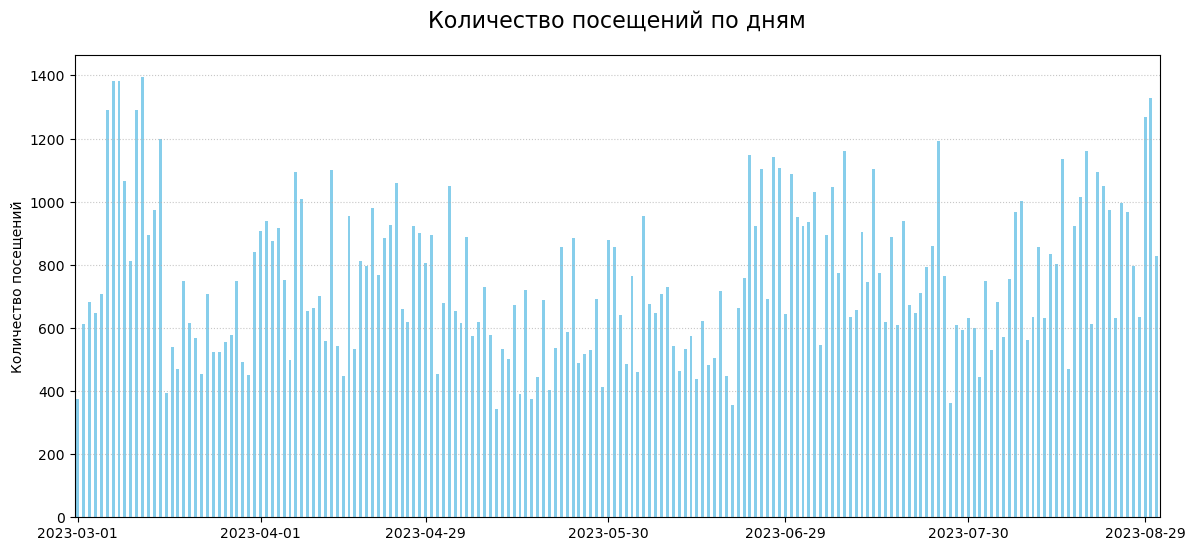

In [21]:
#построение графика "Количество посещений по дням"
def plot_visits(ads, output_path='./charts/total_visits.png'):
    fig, ax = plt.subplots(figsize=(14, 6))
    ads.plot(kind='bar', x='date_group', y='visits', ax=ax, legend=False, color='skyblue')
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=0)
    ax.set_xlabel('')
    ax.set_ylabel('Количество посещений')
    plt.title('Количество посещений по дням', fontsize=16, pad=20)
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.savefig(output_path, bbox_inches='tight')

plot_visits(ads)

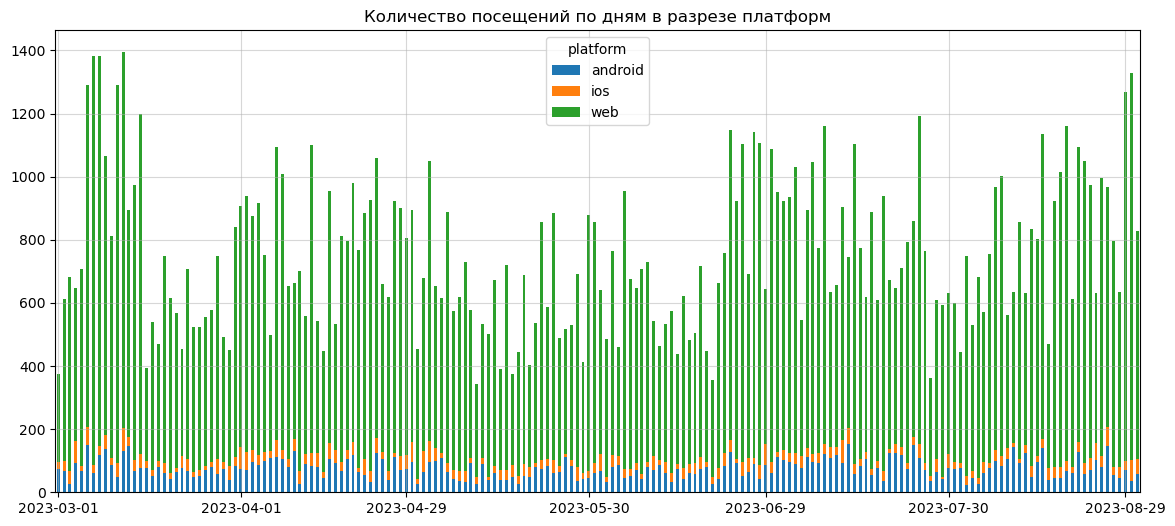

In [22]:
#построение графика "Количество посещений по дням в разрезе платформ"
def plot_visits_by_platform(ads, output_path='./charts/total_visits_platform.png'):
    graph2 = conv.pivot(index='date_group', columns='platform', values='visits')
    graph2.index = graph2.index.date
    fig, ax = plt.subplots(figsize=(14, 6))
    graph2.plot(kind='bar', stacked=True, ax=ax)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.set_title('Количество посещений по дням в разрезе платформ')
    plt.xticks(rotation=0)
    ax.grid(alpha=0.5)
    plt.savefig(output_path, bbox_inches='tight')

plot_visits_by_platform(ads)

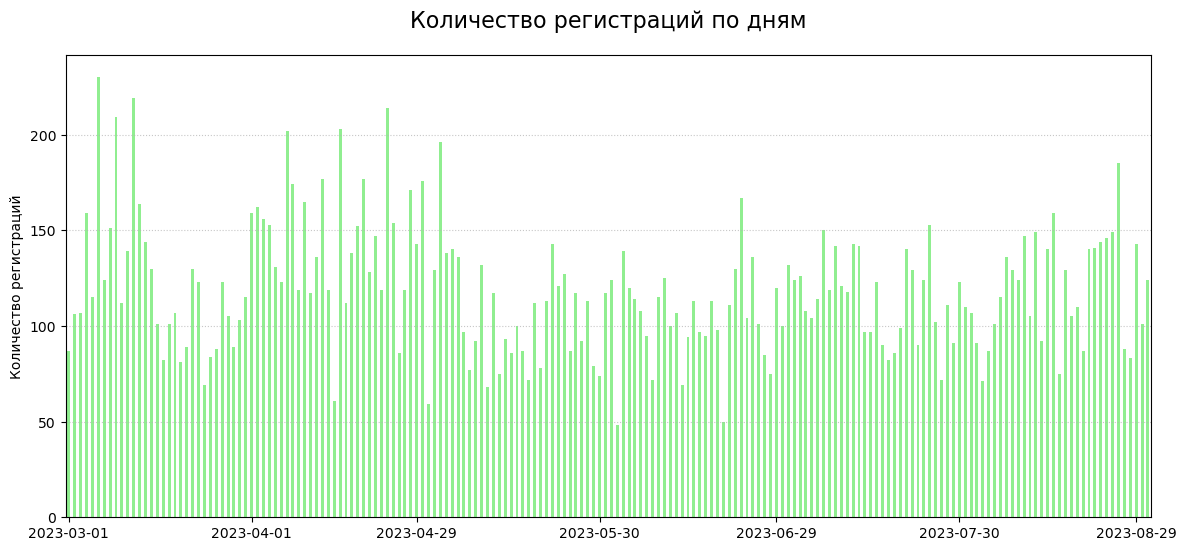

In [23]:
#построение графика "Количество регистраций по дням"
def plot_registrations(ads, output_path='./charts/total_registrations.png'):
    required_columns = {'date_group', 'registrations'}
    if not required_columns.issubset(ads.columns):
          raise ValueError(f"DataFrame должен содержать столбцы: {required_columns}")
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ads.plot(kind='bar', x='date_group', y='registrations', ax=ax, legend=False, color='lightgreen')
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=0)
    ax.set_xlabel('')
    ax.set_ylabel('Количество регистраций')
    plt.title('Количество регистраций по дням', fontsize=16, pad=20)
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.savefig(output_path, bbox_inches='tight')

plot_registrations(ads)

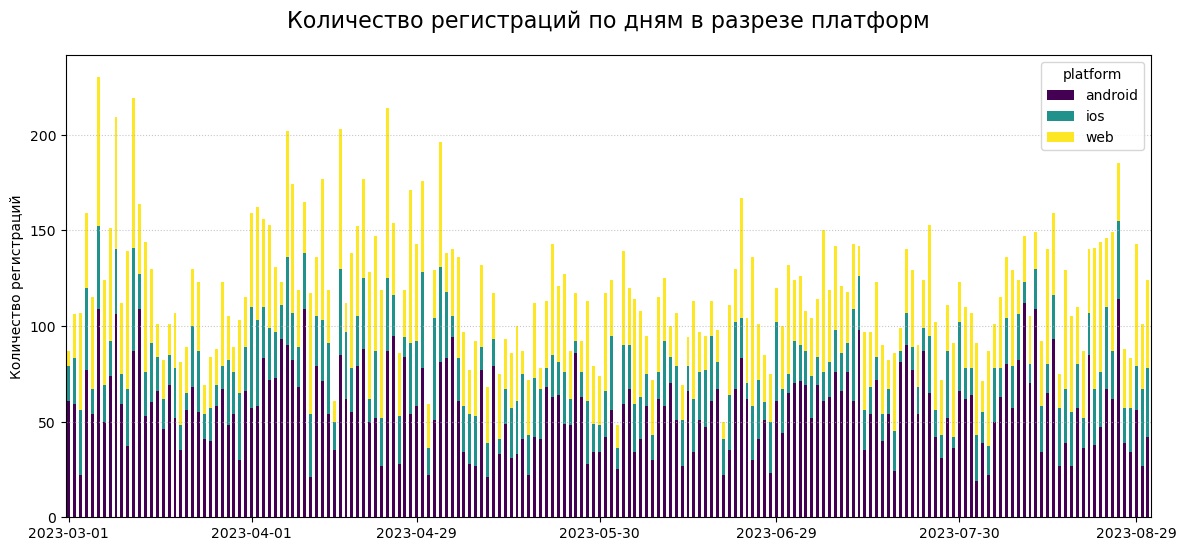

In [24]:
#построение графика "Количество регистраций по дням в разрезе платформ"
def plot_registrations_by_platform(ads, output_path='./charts/total_registrations_platform.png'):
        required_columns = {'date_group', 'platform', 'registrations'}
        if not required_columns.issubset(conv.columns):
            raise ValueError(f"DataFrame должен содержать столбцы: {required_columns}")

        graph4 = conv.pivot(index='date_group', columns='platform', values='registrations')
        graph4.index = graph4.index.date
        fig, ax = plt.subplots(figsize=(14, 6))
        graph4.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.xticks(rotation=0)
        ax.set_xlabel('')
        ax.set_ylabel('Количество регистраций')
        ax.set_title('Количество регистраций по дням в разрезе платформ', fontsize=16, pad=20)
        ax.grid(axis='y', linestyle=':', alpha=0.7)
        plt.savefig(output_path, bbox_inches='tight')

plot_registrations_by_platform(ads)

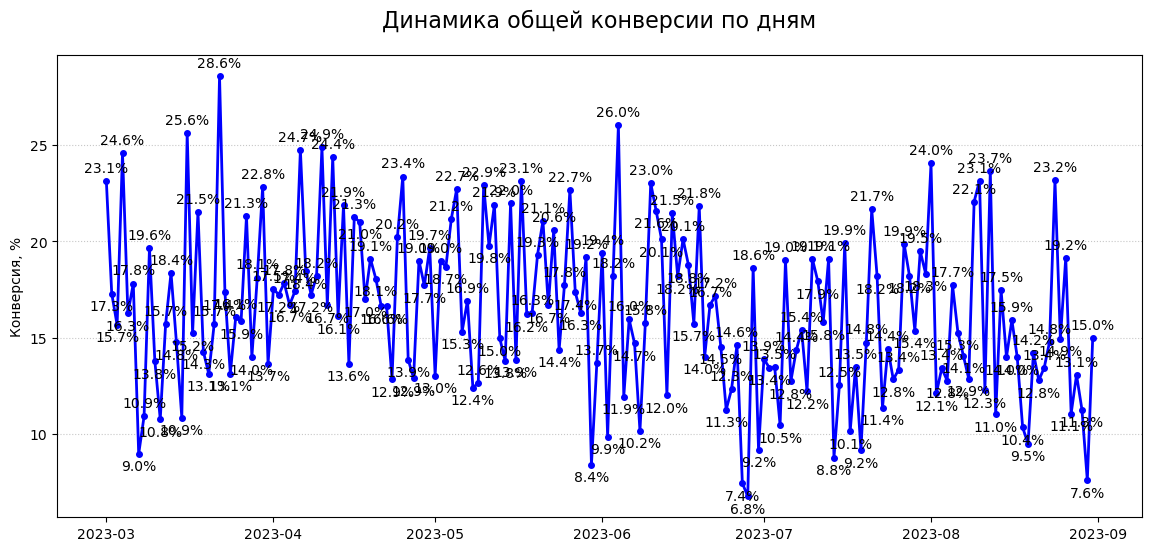

In [25]:
#построение графика "Количество регистраций по дням в разрезе платформ"
def plot_conversion_dynamics(ads, output_path='./charts/total_conv.png'):
    required_columns = {'date_group', 'visits', 'registrations'}
    if not required_columns.issubset(ads.columns):
        raise ValueError(f"DataFrame должен содержать столбцы: {required_columns}")

    graph5 = ads[['date_group', 'visits', 'registrations']].copy()
    graph5['conversion'] = graph5['registrations'] / graph5['visits'] * 100

    fig, ax = plt.subplots(figsize=(14, 6))
    graph5.plot(kind='line', x='date_group', y='conversion', ax=ax, legend=False,
              marker='o', markersize=4, color='blue', linewidth=2)

    previous_conversion = None
    for x, y in zip(graph5['date_group'], graph5['conversion']):
            if previous_conversion is not None:
                va = 'bottom' if y >= previous_conversion else 'top'
            else:
                va = 'bottom'
            offset = 0.3 if va == 'bottom' else -0.3
            plt.text(x, y + offset, f'{y:.1f}%', ha='center', va=va, fontsize=10, color='black')
            previous_conversion = y

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=0)
    ax.set_xlabel('')

    ax.set_ylabel('Конверсия, %')

    plt.title('Динамика общей конверсии по дням', fontsize=16, pad=20)

    plt.grid(axis='y', linestyle=':', alpha=0.7)

    plt.savefig(output_path, bbox_inches='tight')

plot_conversion_dynamics(ads)

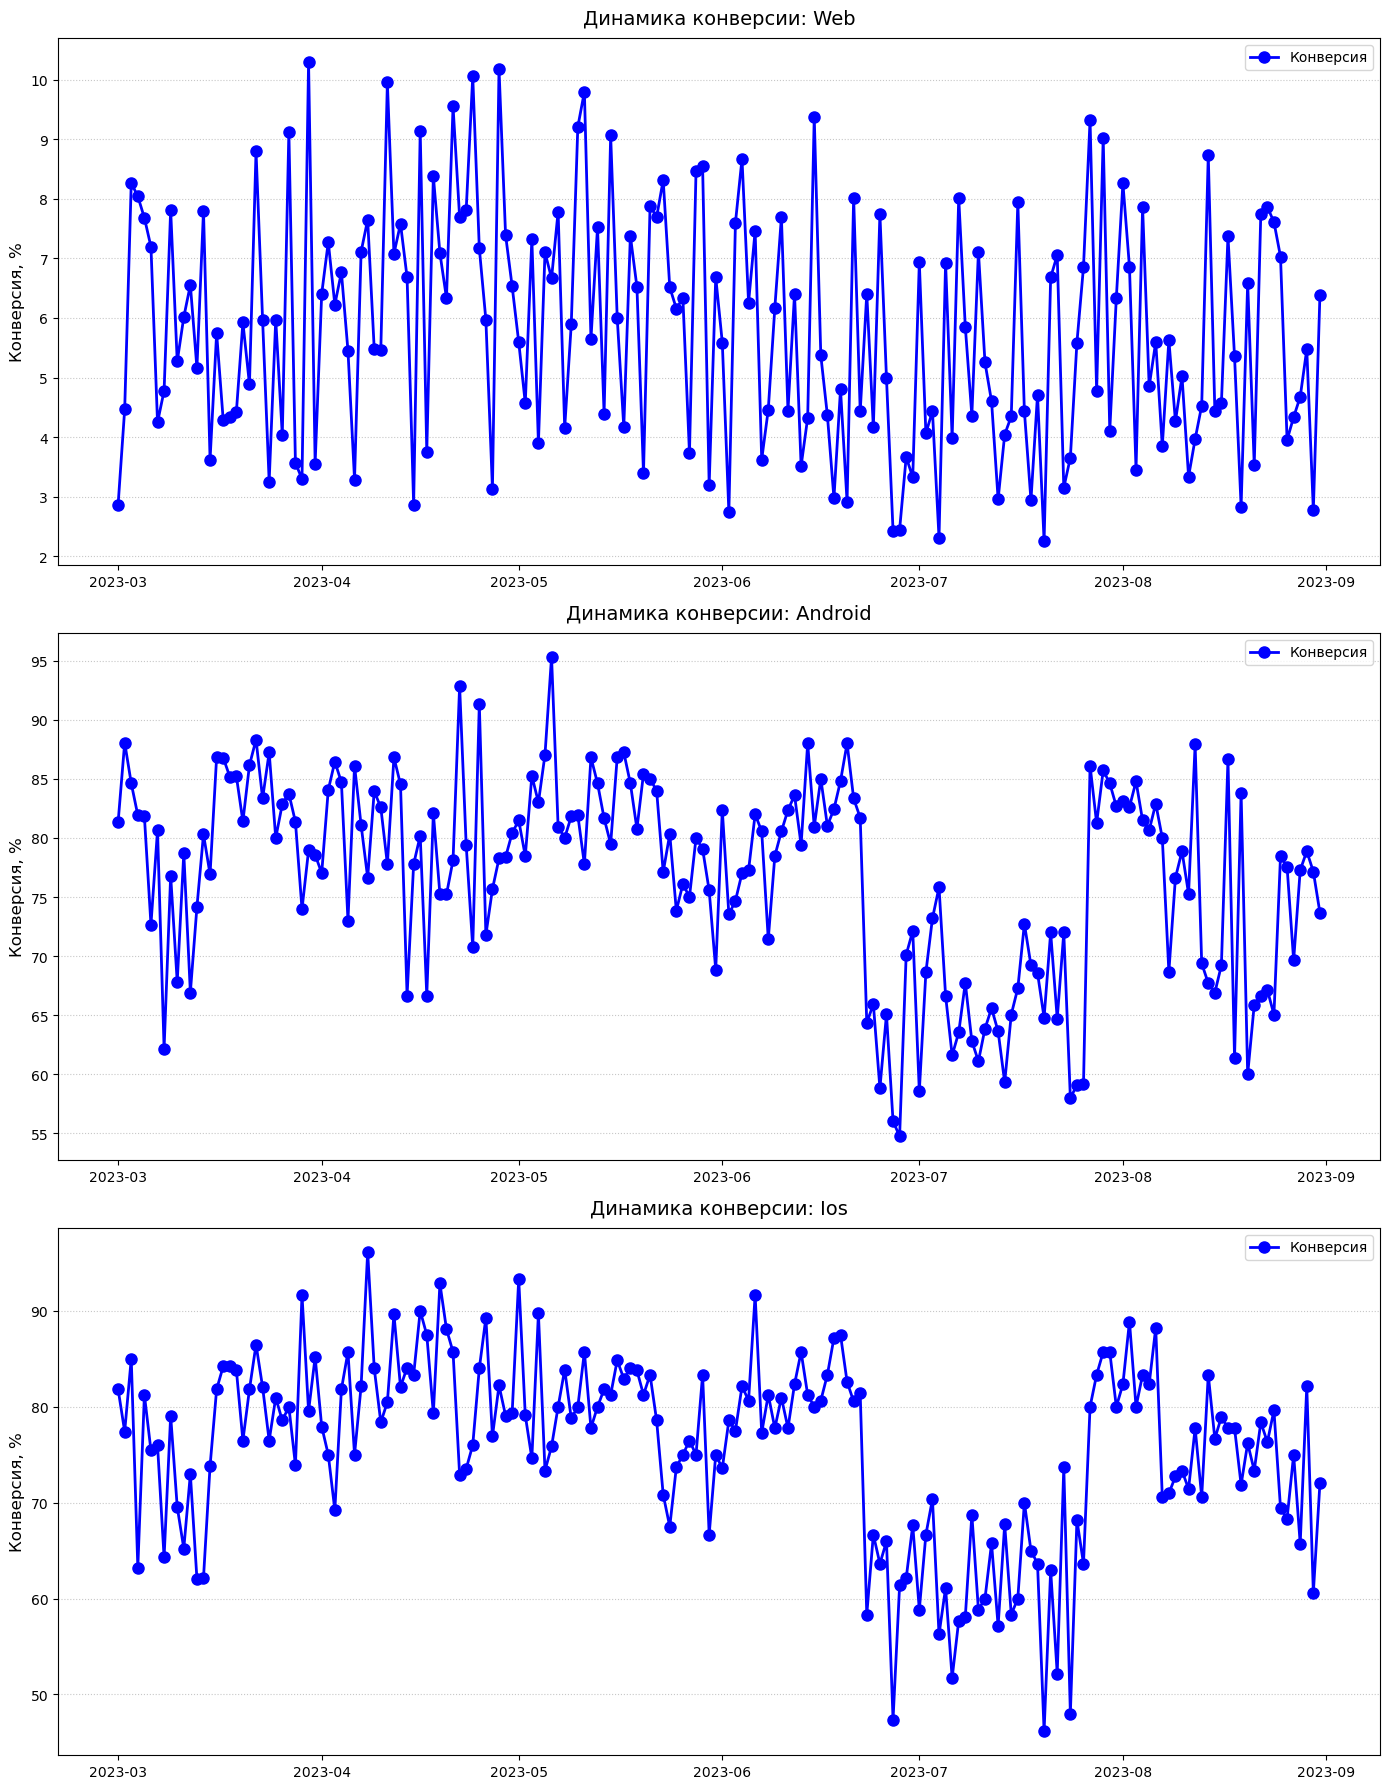

In [26]:
#построение графика "Динамика конверсии"
def plot_conversion_by_platform(ads, output_path='./charts/total_conv_platform.png'):
        required_columns = {'date_group', 'platform', 'conversion'}
        if not required_columns.issubset(conv.columns):
            raise ValueError(f"DataFrame должен содержать столбцы: {required_columns}")

        fig, axes = plt.subplots(3, 1, figsize=(14, 18))
        platforms = ['web', 'android', 'ios']

        for i, platform in enumerate(platforms):
            graph6 = conv[conv['platform'] == platform]

            axes[i].plot(graph6['date_group'], graph6['conversion'], marker='o', markersize=8,
                         linewidth=2, color='blue', label='Конверсия')

            axes[i].set_title(f'Динамика конверсии: {platform.capitalize()}', fontsize=14, pad=10)

            axes[i].set_xlabel('')
            axes[i].tick_params(axis='x', rotation=0)
            axes[i].set_ylabel('Конверсия, %', fontsize=12)
            axes[i].grid(axis='y', linestyle=':', alpha=0.7)
            axes[i].legend(loc='upper right', fontsize=10)

        plt.tight_layout()
        plt.savefig(output_path, bbox_inches='tight')

plot_conversion_by_platform(ads)

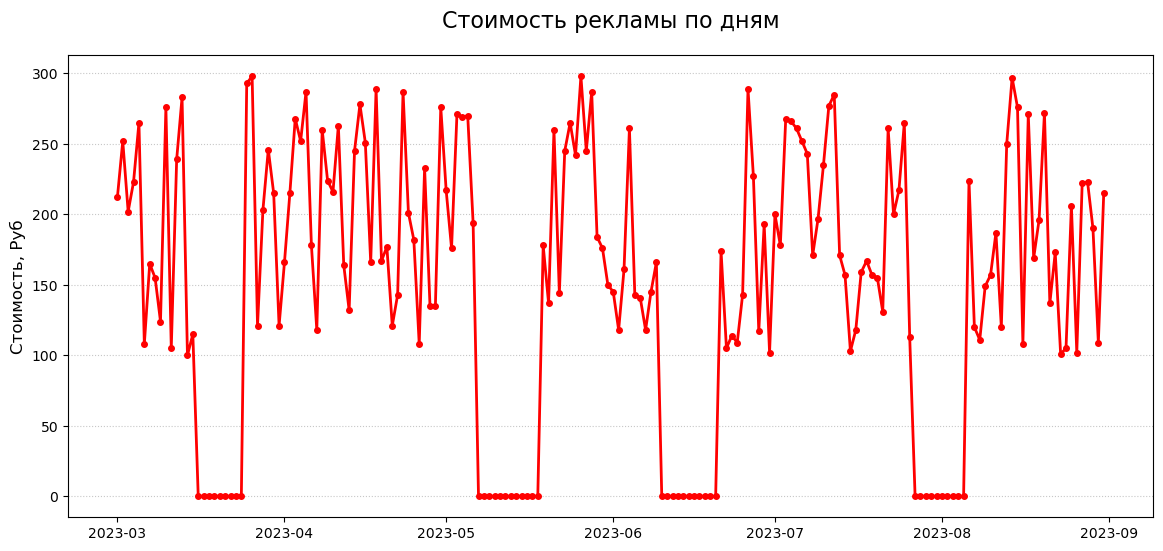

In [27]:
#построение графика "Стоимость рекламы по дням"
def plot_ads_cost(ads, output_path='./charts/ads_cost.png'):

        required_columns = {'date_group', 'cost'}
        if not required_columns.issubset(ads.columns):
            raise ValueError(f"DataFrame должен содержать столбцы: {required_columns}")

        fig, ax = plt.subplots(figsize=(14, 6))
        ads.plot(kind='line', x='date_group', y='cost', ax=ax, legend=False,
                 marker='o', markersize=4, color='red', linewidth=2)
        previous_cost = None
        for x, y in zip(ads['date_group'], ads['cost']):
            if y != 0:
                if previous_cost is not None:
                    va = 'bottom' if y >= previous_cost else 'top'
                else:
                    va = 'bottom'
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.xticks(rotation=0)
        ax.set_xlabel('')
        ax.set_ylabel('Стоимость, Руб', fontsize=12)
        plt.title('Стоимость рекламы по дням', fontsize=16, pad=20)
        plt.grid(axis='y', linestyle=':', alpha=0.7)
        plt.savefig(output_path, bbox_inches='tight')

plot_ads_cost(ads)

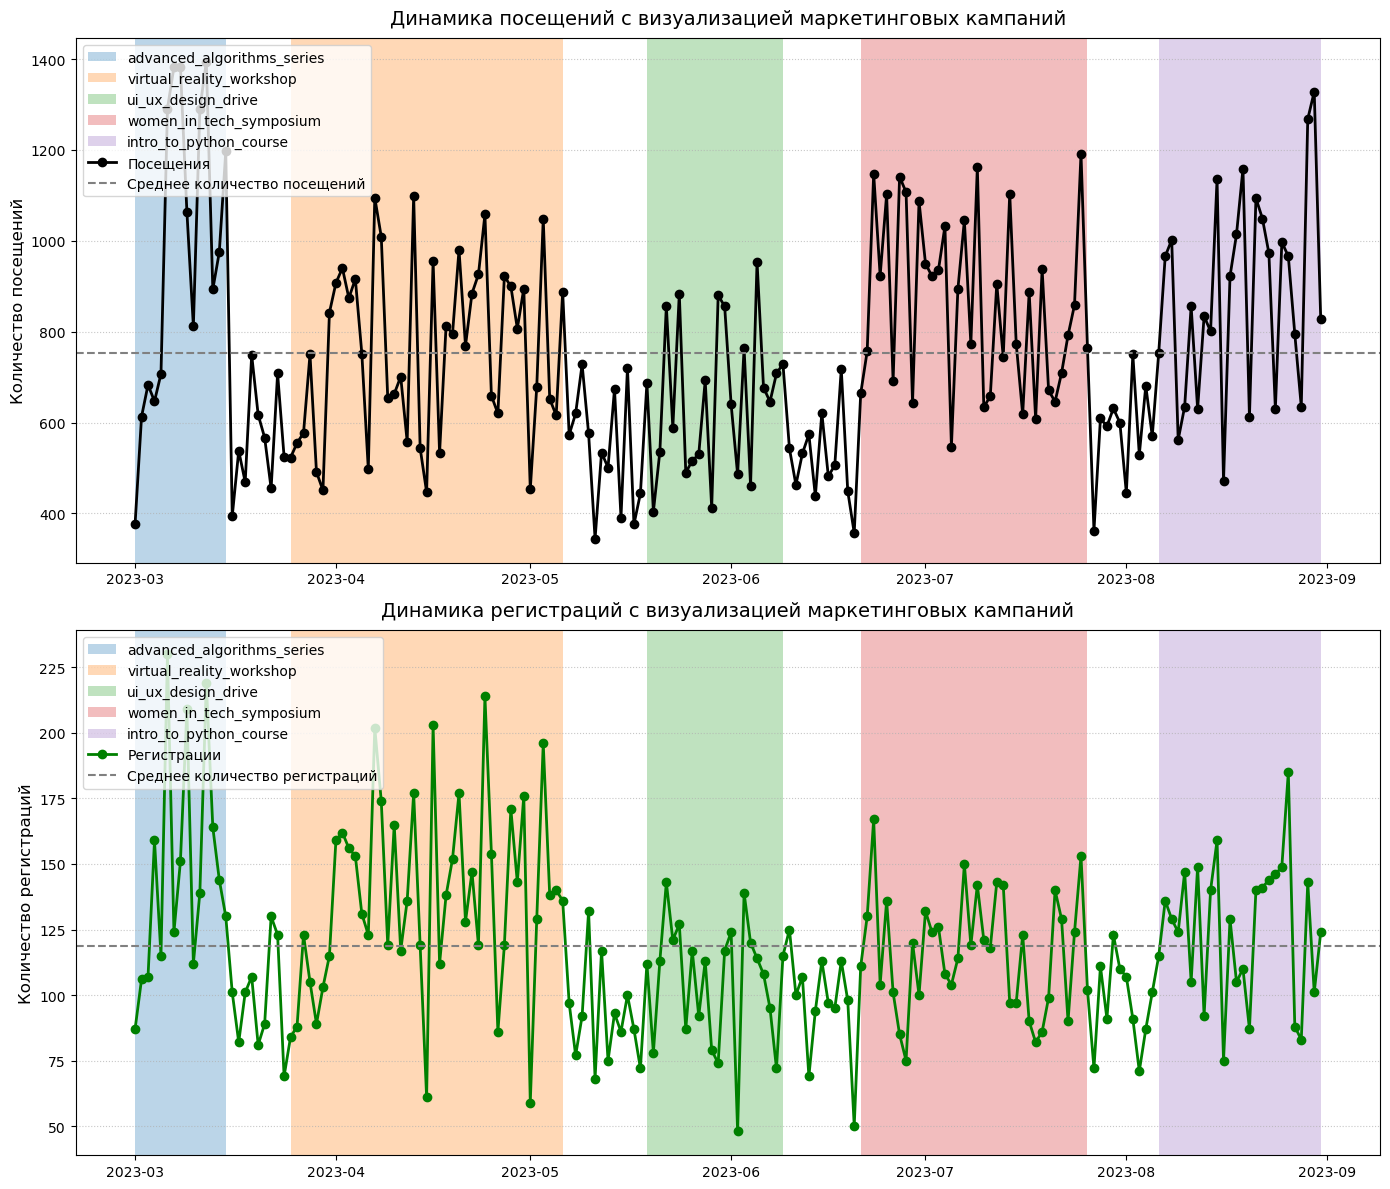

In [28]:
#построение графика "Динамика регистраций с визуализацией маркетинговых кампаний"
def plot_ads_campaigns(ads, output_path='./charts/total.png'):
        required_columns = {'date_group', 'visits', 'registrations', 'utm_campaign'}
        if not required_columns.issubset(ads.columns):
            raise ValueError(f"DataFrame должен содержать столбцы: {required_columns}")

        graph8 = ads.groupby('utm_campaign').agg({'date_group': ['min', 'max']})
        graph8.columns = ['start_ads', 'end_ads']
        graph8 = graph8.sort_values('end_ads').reset_index()
        fig, axes = plt.subplots(2, 1, figsize=(14, 12))

        for i, name, start, end in zip(graph8.index, graph8['utm_campaign'], graph8['start_ads'], graph8['end_ads']):
            color = plt.cm.tab10(i)
            axes[0].axvspan(start, end, fc=color, alpha=0.3, label=name)
            axes[1].axvspan(start, end, fc=color, alpha=0.3, label=name)

        axes[0].plot(ads['date_group'], ads['visits'], color='black', marker='o', markersize=6, linewidth=2, label='Посещения')
        axes[0].axhline(ads['visits'].mean(), linestyle='--', color='gray', label='Среднее количество посещений')
        axes[0].set_title('Динамика посещений с визуализацией маркетинговых кампаний', fontsize=14, pad=10)
        axes[0].set_ylabel('Количество посещений', fontsize=12)
        axes[0].grid(axis='y', linestyle=':', alpha=0.7)
        axes[0].legend(loc='upper left', fontsize=10)

        axes[1].plot(ads['date_group'], ads['registrations'], color='green', marker='o', markersize=6, linewidth=2, label='Регистрации')
        axes[1].axhline(ads['registrations'].mean(), linestyle='--', color='gray', label='Среднее количество регистраций')
        axes[1].set_title('Динамика регистраций с визуализацией маркетинговых кампаний', fontsize=14, pad=10)
        axes[1].set_ylabel('Количество регистраций', fontsize=12)
        axes[1].grid(axis='y', linestyle=':', alpha=0.7)
        axes[1].legend(loc='upper left', fontsize=10)

        plt.tight_layout()

        plt.savefig(output_path, bbox_inches='tight')

plot_ads_campaigns(ads)